In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using SharedArrays
using Plots
using Optim

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1273
┌ Info: Precompiling Thyrosim [7ef34fca-2b35-11e9-1aeb-a527bedb189e]
└ @ Base loading.jl:1273
┌ Info: Precompiling DiffEqParamEstim [1130ab10-4a5a-5621-a13d-e4788d82bd4c]
└ @ Base loading.jl:1273


# Import data

In [2]:
#schneider data
train, test, toy = schneider_data();

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
jonklaas_tspan = (0.0, 8.0)

(0.0, 8.0)

# Helper functions needed for simulations

In [3]:
function one_simulation(
    current_iter::SharedArray,
    fitting_index::SharedArray, 
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    tspan::Float64,
    initial_tsh::Float64,
    euthyroid_dose::Float64,
    initial_dose::Float64
    )
    
    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex)
    ic[7] = initial_tsh
    tot_loss = zero(Int)
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= current_iter
    
    # calculate error for euthyroid dose
    p[55] = euthyroid_dose / 777.0
    prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
    sol   = solve(prob, save_idxs=7)
    
    #increment error
    tot_loss += compute_euthyroid_dose_l2_error(sol)
    
    # when initial dose != euthyroid dose, calculate error
    if initial_dose != euthyroid_dose
        p[55] = initial_dose / 777.0
        prob = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol = solve(prob, save_idxs=7)
        tot_loss += compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose)
    end

    return tot_loss
end

# gives 400 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end

# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end

# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end

function compute_euthyroid_dose_error(sol)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24]
        if !all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end
  
function compute_initial_dose_error(sol)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24]
        if all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end
                      
# distance to set penalty where the set C = [0.5, 4.5]
function compute_euthyroid_dose_l2_error(sol)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        tsh = sol.u[end]
        if tsh > 4.5
            tot_loss += (tsh - 4.5)^2
        elseif tsh < 0.5
            tot_loss += (0.5 - tsh)^2
        end
    end
    return tot_loss
end
                                    
# distance to set penalty where the set C = [0.0, 0.5] ∪ [4.5, Inf]                       
function compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        tsh = sol.u[end]
        if euthyroid_dose > initial_dose && tsh < 4.5 #original TSH too high
            tot_loss += (4.5 - tsh)^2
        elseif euthyroid_dose < initial_dose && tsh > 0.5 #original TSH too low
            tot_loss += (0.5 - tsh)^2
        end
    end
    return tot_loss
end
                     
function blakesley_tsh_error(sol, time, data, Vtsh)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[2] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 3])^2
        end
    end
    return tot_loss
end
            
function blakesley_t4_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
    end
    return tot_loss
end
                                                
function jonklaas_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T3_predicted = sol(time[i]) * 651.0 / Vp
            tot_loss += (T3_predicted - data[i])^2
        end
    end
    return tot_loss
end

jonklaas_error (generic function with 1 method)

# Result

In [4]:
fitting_index = SharedArray{Int}([28; 45; 30; 31; 49; 50; 51; 52; 53; 54])
initial_guess = [ 0.8892067744277633;1.6882221360501146;69.90379778202167;38.71161774205076;  
                  6.039888256864343; 3.7006563259936747;8.748185980217668;6.590694001313398; 
                  2.896554559451672;13.013203952637502]
train_minimizer = [0.6039222046641435, 22.087463157341936, 103.36585765448072, 
            89.55523275731187, 67.93860849674263, 3.646391720870975, 0.0400965033683874, 
            7.134927653438794, 5.973788223841496, 23.971174120935313]

10-element Array{Float64,1}:
   0.6039222046641435
  22.087463157341936 
 103.36585765448072  
  89.55523275731187  
  67.93860849674263  
   3.646391720870975 
   0.0400965033683874
   7.134927653438794 
   5.973788223841496 
  23.971174120935313 

## Blakesley data (T4 and TSH data)

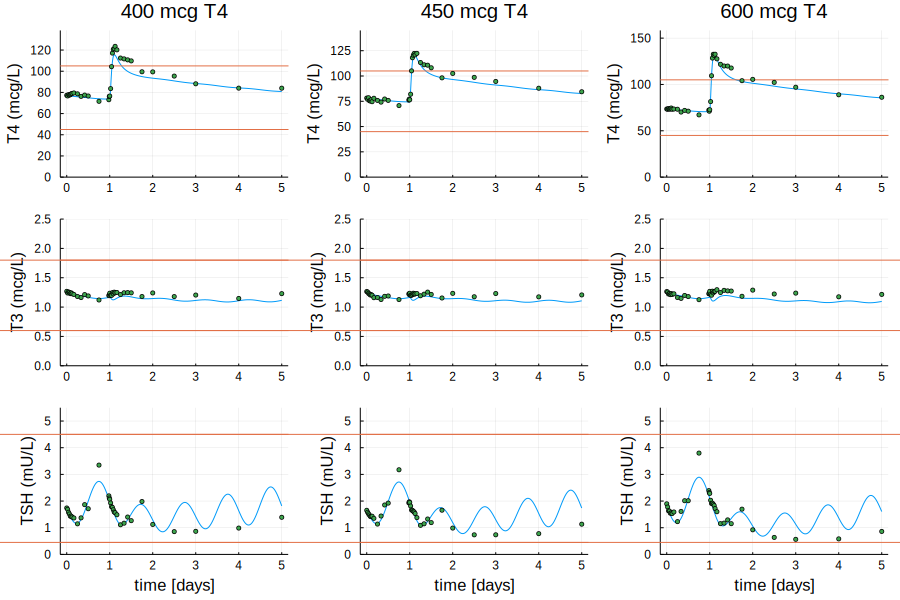

In [10]:
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
p[fitting_index] = train_minimizer

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
set_patient_ic!(ic, p, T4_init_400, T3_init_400, TSH_init_400, steady_state=true, set_tsh_lag=true)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400", title="400 mcg T4")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
set_patient_ic!(ic, p, T4_init_450, T3_init_450, TSH_init_450, steady_state=true, set_tsh_lag=true)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450", title="450 mcg T4")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
set_patient_ic!(ic, p, T4_init_600, T3_init_600, TSH_init_600, steady_state=true, set_tsh_lag=true)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600", title="600 mcg T4")

blakesley_plot = plot(a, b, c, layout=(1, 3), size=(900, 600))

## Jonklaas data (T3 data)

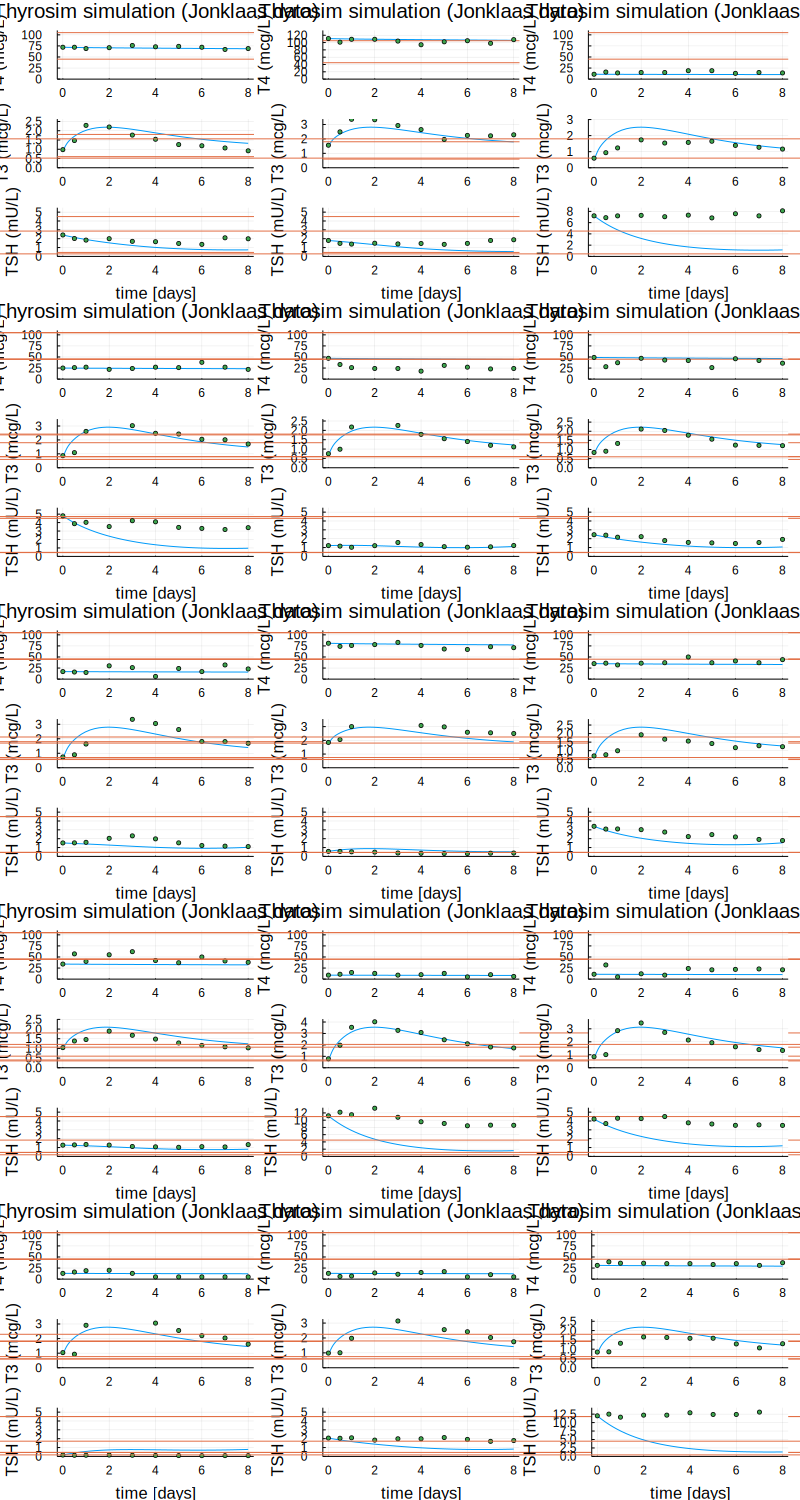

In [6]:
graphs = Vector{Any}(undef, 15)
for i in 1:15
    height, weight, sex = patient_param[i, :]
    T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
    T3dose = patient_dose[i]
    ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
    set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
    p[55] = 0.0
    p[56] = T3dose / 651.0
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    p[fitting_index] = train_minimizer
    prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
    sol = solve(prob)
    graphs[i] = plot_jonklaas(sol, patient_t4[i, :], patient_t3[i, :], patient_tsh[i, :])
end
plot(graphs..., layout=(5, 3), size=(800, 1500))